# Lab 6: Clustering Algorithms

## Dataset : Mall Customers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Plotting defaults
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 120


## 1. Data Exploration and Preprocessing

In [3]:
csv_path = 'D:\ML Lab\Lab06\Mall_Customers.csv'  

df = pd.read_csv(csv_path)
print('Shape:', df.shape)
df.head()

Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Data selection (two features)

In [6]:
features = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
features.columns = ['Income', 'Score']

In [7]:
# Optional standardization (not strictly needed for these two features,but can help certain algorithms and distance-based plots).
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

print('Selected features shape:', X.shape)

Selected features shape: (200, 2)


### Initial Visualization 

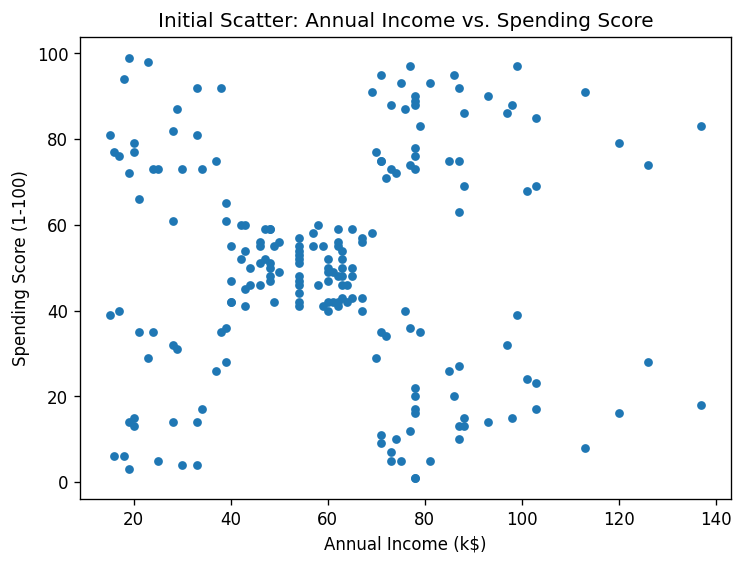

In [8]:
plt.figure()
plt.scatter(features['Income'], features['Score'], s=18)
plt.title('Initial Scatter: Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## 2. K-Means Clustering

### Elbow Method 

In [9]:
wcss = []
K_RANGE = range(1, 11)
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)

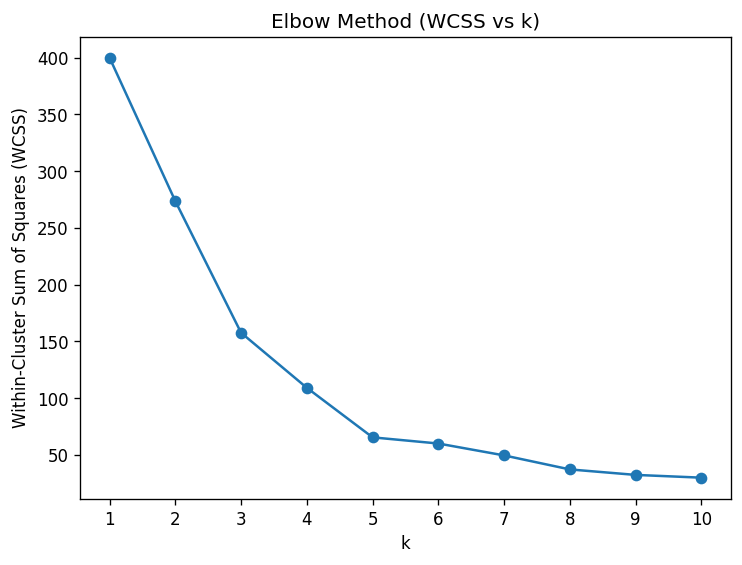

In [10]:
plt.figure()
plt.plot(list(K_RANGE), wcss, marker='o')
plt.title('Elbow Method (WCSS vs k)')
plt.xlabel('k')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(list(K_RANGE))
plt.show()

In [11]:
# Simple elbow heuristic: choose k at the largest relative drop of WCSS
# (excluding k=1 to avoid division by zero issues).
rel_drop = [0] + [(wcss[i-1] - wcss[i]) / wcss[i-1] for i in range(1, len(wcss))]
k_elbow = max(range(2, len(rel_drop)), key=lambda i: rel_drop[i])  # start from 2
print('Heuristic elbow k =', k_elbow)

Heuristic elbow k = 2


### Apply K-Means with k_elbow

In [12]:
kmeans = KMeans(n_clusters=k_elbow, n_init='auto', random_state=42)
kmeans_labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

In [13]:
# Inverse-transform centroids for plotting in original units
centroids_orig = scaler.inverse_transform(centroids)

### Visualize K-Means Results

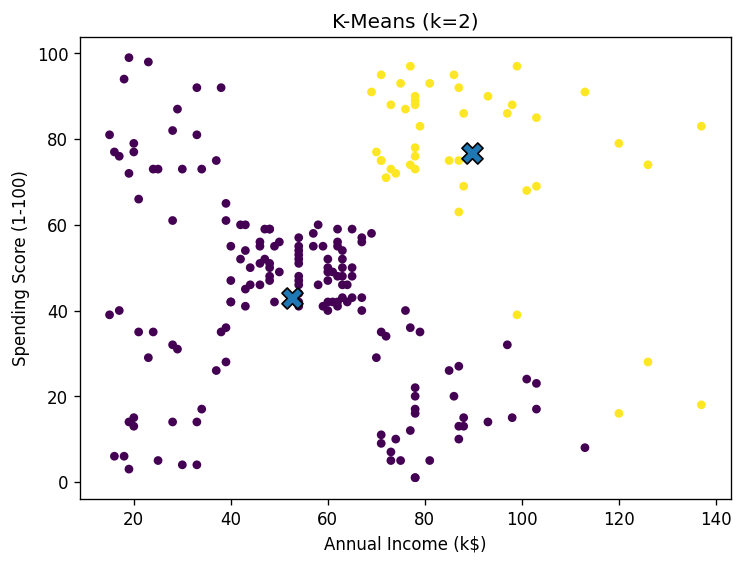

In [14]:
plt.figure()
plt.scatter(features['Income'], features['Score'], c=kmeans_labels, s=18)
plt.scatter(centroids_orig[:,0], centroids_orig[:,1], marker='X', s=160, edgecolor='k')
plt.title(f'K-Means (k={k_elbow})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [15]:
km_sil = silhouette_score(X, kmeans_labels) if len(set(kmeans_labels)) > 1 else np.nan
print('K-Means silhouette score:', km_sil)

K-Means silhouette score: 0.3973270007887498


## 3. Agglomerative Hierarchical Clustering

### Dendrogram (Ward linkage)

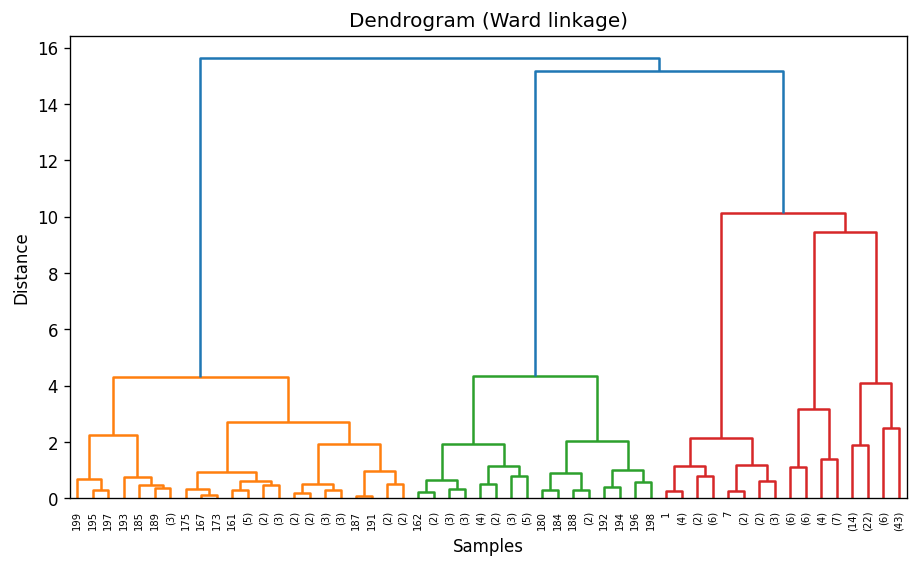

In [17]:
Z = linkage(X, method='ward')
plt.figure(figsize=(9, 5))
dendrogram(Z, truncate_mode='level', p=5)  # truncated for readability
plt.title('Dendrogram (Ward linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [18]:
# Choose number of clusters 
# We'll try n_clusters from 2..10 and pick the one with the best silhouette score
best_aggl_n = None
best_aggl_s = -np.inf
for k in range(2, 11):
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_k = ag.fit_predict(X)
    s = silhouette_score(X, labels_k)
    if s > best_aggl_s:
        best_aggl_s, best_aggl_n = s, k

print('Best Agglomerative k by silhouette:', best_aggl_n, 'score=', round(best_aggl_s, 4))

agglom = AgglomerativeClustering(n_clusters=best_aggl_n, linkage='ward')
aggl_labels = agglom.fit_predict(X)

Best Agglomerative k by silhouette: 5 score= 0.5538


### Visualize Agglomerative Results

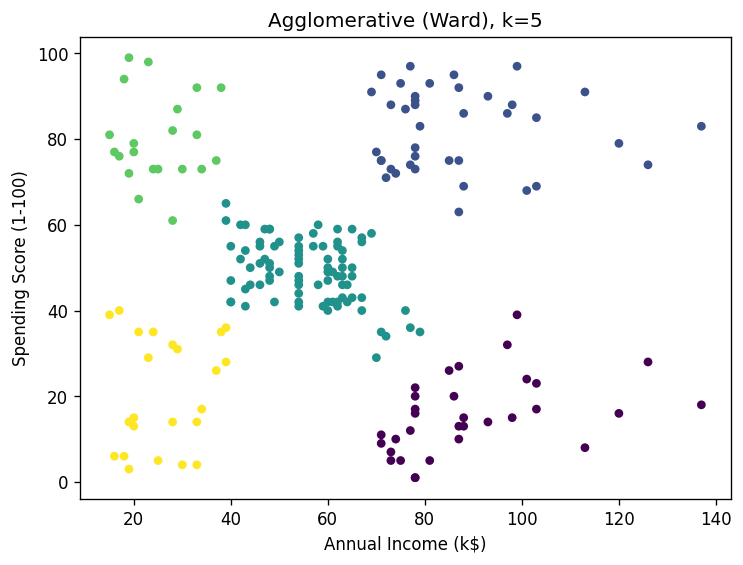

Agglomerative silhouette score: 0.5538089226688662


In [19]:
plt.figure()
plt.scatter(features['Income'], features['Score'], c=aggl_labels, s=18)
plt.title(f'Agglomerative (Ward), k={best_aggl_n}')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

ag_sil = silhouette_score(X, aggl_labels)
print('Agglomerative silhouette score:', ag_sil)

## 4. DBSCAN Clustering

In [20]:
eps_grid = [2, 3, 4, 5, 6, 7]
min_samples = 5

db_results = []
for eps in eps_grid:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db_labels = db.fit_predict(X)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise = np.sum(db_labels == -1)
    sil = silhouette_score(X, db_labels) if n_clusters >= 2 else np.nan
    db_results.append((eps, n_clusters, n_noise, sil))

db_results_df = pd.DataFrame(db_results, columns=['eps', 'n_clusters', 'n_noise', 'silhouette'])
db_results_df

,eps,n_clusters,n_noise,silhouette
0,2,1,0,NaN
1,3,1,0,NaN
2,4,1,0,NaN
3,5,1,0,NaN
4,6,1,0,NaN
5,7,1,0,NaN


In [21]:
# Pick the eps that gives the best silhouette among valid clusterings (>=2 clusters)
valid = db_results_df.dropna(subset=['silhouette'])
if not valid.empty:
    best_row = valid.sort_values('silhouette', ascending=False).iloc[0]
    best_eps = float(best_row['eps'])
else:
    # fallback to suggested starting point
    best_eps = 5.0

print('Chosen eps for DBSCAN:', best_eps)

db_best = DBSCAN(eps=best_eps, min_samples=5)
db_labels = db_best.fit_predict(X)

Chosen eps for DBSCAN: 5.0


### Visualization

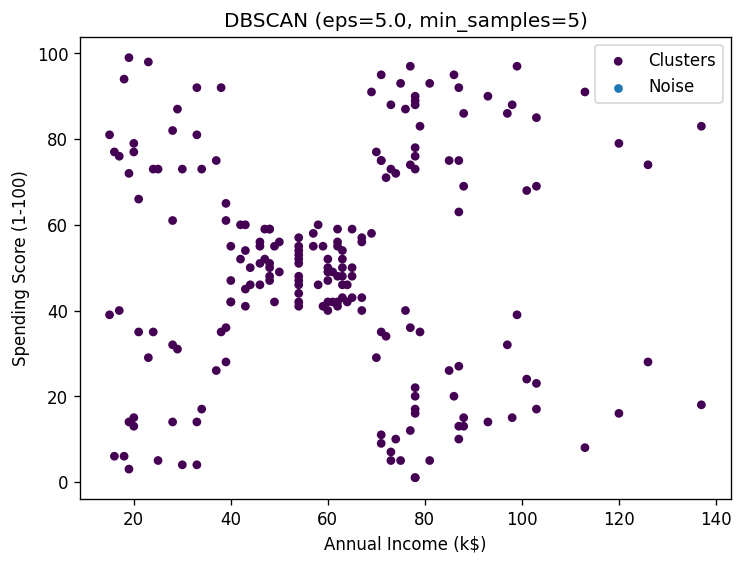

DBSCAN clusters: 1 | noise points: 0 | silhouette: nan


In [22]:
plt.figure()
mask_noise = (db_labels == -1)
plt.scatter(features.loc[~mask_noise, 'Income'], features.loc[~mask_noise, 'Score'],
            c=db_labels[~mask_noise], s=18, label='Clusters')
plt.scatter(features.loc[mask_noise, 'Income'], features.loc[mask_noise, 'Score'],
            s=18, label='Noise')
plt.title(f'DBSCAN (eps={best_eps}, min_samples=5)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

db_n_clusters = len(set(db_labels)) - (1 if -1 in set(db_labels) else 0)
db_n_noise = int(np.sum(db_labels == -1))
db_sil = silhouette_score(X, db_labels) if db_n_clusters >= 2 else np.nan
print('DBSCAN clusters:', db_n_clusters, '| noise points:', db_n_noise, '| silhouette:', db_sil)

## 5. Analysis & Questions — Answers

### 1. Optimal Clusters
- **K-Means**:  
  - The elbow heuristic suggested **k = 2**, but the silhouette score was only **0.3973**.  
  - This indicates that 2 clusters separate some structure, but the compactness is not very strong.  
- **Hierarchical (Agglomerative, Ward linkage)**:  
  - The best silhouette score was found at **k = 5**, with **0.5538**.  
  - This is significantly higher than K-Means, showing more well-formed clusters.

### 2. Cluster Comparison
- **K-Means vs Agglomerative**:  
  - K-Means (k=2) split customers broadly into two groups (likely low vs. high spenders/income).  
  - Agglomerative (k=5) revealed finer segments and achieved higher silhouette, meaning the partitions are more natural for this dataset.  
  - K-Means boundaries are centroid-based (circular), while Agglomerative allowed more nuanced grouping.  
- **DBSCAN**:  
  - DBSCAN failed to discover meaningful clusters with tested eps values (2–7).  
  - It always returned **1 cluster with 0 noise points**, silhouette = NaN.  
  - Hence, DBSCAN did not separate the data well in this case.

### 3. DBSCAN Performance
- **Chosen eps**: 5.0 (fallback, since no valid silhouette was available).  
- **Number of clusters**: 1.  
- **Noise points**: 0.  
- **Interpretation**: DBSCAN could not detect the structure (all points treated as one dense group), so it is not suitable for this dataset with default scaling.

### 4. Algorithm Suitability
- **Best fit**: Agglomerative Hierarchical Clustering with **k=5**.  
- **Why**:  
  - Achieved the best silhouette (0.5538),  
  - Segments are meaningful,  
  - Matches the natural compact groupings visible in the Income vs. Spending Score scatterplot.  
- **K-Means** was weaker with only k=2 found, and **DBSCAN** failed to form clusters.  
- Thus, **Agglomerative is the most suitable algorithm** here.

### 5. Real-World Application
- **High income, high score** → VIP experiences, exclusive memberships.  
- **High income, low score** → personalized offers to increase engagement (e.g., trial luxury products).  
- **Low income, high score** → loyalty discounts, promotional bundles.  
- **Moderate income & score** → value packs, cross-selling strategies.  
- **Other small/niche groups** → individualized campaigns.
